# Linear Neural Network Classification

## Image Dataset

In the following sections, our discussion will center on the Fashion-MNIST dataset (Xiao et al., 2017) where consists of images representing 10 categories of clothing at the same pixel resolution.

In [1]:
%matplotlib inline
import time
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

### Loading the Dataset

In [2]:
class FashionMNIST(d2l.DataModule):  # @save
    """The Fashion-MNIST dataset."""
    def __init__(self, batch_size=64, resize=(28, 28), root="./data", download=False):
        super().__init__()
        self.save_hyperparameters()
        self.root = root   # ✅ override default "../data"

        trans = transforms.Compose([
            transforms.Resize(resize),
            transforms.ToTensor()
        ])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=download
        )
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=download
        )


Fashion-MNIST consists of images from 10 categories, each represented by 6000 images in the training dataset and by 1000 in the test dataset. 

In [3]:
data = FashionMNIST(resize=(28, 28), root="/tmp/fashion_mnist", download=False)
len(data.train), len(data.val)

(60000, 10000)

The images are grayscale and upscaled to  $32 \times 32$ pixels in resolution above. 

In [4]:
data.train[2][1]#.shape


0

The Fashion-MNIST categories are labeled with names that are easily understood by humans.

In [5]:
@d2l.add_to_class(FashionMNIST)  #@save
def text_labels(self, indices):
    """Return text labels."""
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]

### Minibatch

For convenience, we rely on the built-in data iterator to read from the training and test sets instead of implementing one manually.

In [6]:
@d2l.add_to_class(FashionMNIST)  #@save
def get_dataloader(self, train):
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=self.num_workers)

In [7]:
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

torch.Size([64, 1, 28, 28]) torch.float32 torch.Size([64]) torch.int64


To illustrate this, we load a minibatch of images using the `train_dataloader` method, which provides 64 images.

In [8]:
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

torch.Size([64, 1, 28, 28]) torch.float32 torch.Size([64]) torch.int64


Let’s look at the time it takes to read the images. 

In [9]:
tic = time.time()
for X, y in data.train_dataloader():
    continue
f'{time.time() - tic:.2f} sec'

'2.14 sec'

### Visualization

The helper function `show_images` allows us to display the images along with their corresponding labels.

In [10]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    raise NotImplementedError

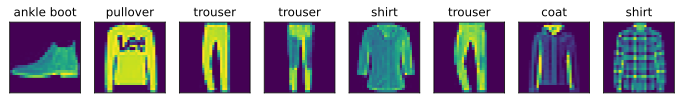

In [11]:
@d2l.add_to_class(FashionMNIST)  #@save
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)
batch = next(iter(data.val_dataloader()))
data.visualize(batch)

## The Base Classification Model

This section introduces a base class for classification models, designed to streamline and simplify future implementations.

### The Classifier Class

In [12]:
class Classifier(d2l.Module):  #@save
    """The base class of classification models."""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)

In [13]:
@d2l.add_to_class(d2l.Module)  #@save
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr=self.lr)

### Accuracy

In classification tasks, we select the class with the highest predicted probability as the output, and accuracy is defined as the fraction of predictions that match the true labels.

In [14]:
@d2l.add_to_class(Classifier)  #@save
def accuracy(self, Y_hat, Y, averaged=True):
    """Compute the number of correct predictions."""
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    preds = Y_hat.argmax(axis=1).type(Y.dtype)
    compare = (preds == Y.reshape(-1)).type(torch.float32)
    return compare.mean() if averaged else compare

## Softmax Regression, Implementation from Scratch

### The Softmax

For a matrix $X$, we can sum either all elements by default or restrict the summation to a specific axis. The `axis` parameter allows us to calculate sums across rows or columns.

In [15]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdims=True), X.sum(1, keepdims=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

The softmax computation involves three steps: (i) exponentiating each element, (ii) summing the values in each row to obtain the normalization constant for that example, and (iii) dividing each row’s elements by its normalization constant so that the outputs sum to 1.

In [16]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

For any input $X$, each element is transformed into a nonnegative value. Each row is then normalized so that its entries sum to 1, satisfying the requirements of a probability distribution.

In [17]:
X = torch.rand((2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.2040, 0.1205, 0.1905, 0.2233, 0.2617],
         [0.2793, 0.1966, 0.1813, 0.1883, 0.1544]]),
 tensor([1., 1.]))

### The Model

We now implement the softmax regression model. In softmax regression, the network’s output size must match the number of classes. Therefore, with a dataset containing 10 classes, the model’s output dimension is set to 10.

In [18]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

The code below defines how the network maps each input to an output. 

In [19]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    X = X.reshape((-1, self.W.shape[0]))
    return softmax(torch.matmul(X, self.W) + self.b)

### The Cross-Entropy Loss

Next we need to implement the cross-entropy loss function.

Recall that cross-entropy takes the negative log-likelihood of the predicted probability as- signed to the true label. For efficiency we avoid Python for-loops and use indexing instead. In particular, the one-hot encoding in y allows us to select the matching terms in y_hat.

To see this in action we create sample data y_hat with 2 examples of predicted probabilities over 3 classes and their corresponding labels y. The correct labels are 0 and 2 respectively (i.e., the first and third class). Using y as the indices of the probabilities in y_hat, we can pick out terms efficiently.

In [20]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [21]:
def cross_entropy(y_hat, y, test=False):
    if test:
        print('print the highest probabilities', y_hat[list(range(len(y_hat))), y])
        print('and their logarithm', torch.log(y_hat[list(range(len(y_hat))), y]))
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

cross_entropy(y_hat, y, test=True)

print the highest probabilities tensor([0.1000, 0.5000])
and their logarithm tensor([-2.3026, -0.6931])


tensor(1.4979)

In [22]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

### Training

We reuse the fit method defined in previous sections to train the model with 10 epochs.

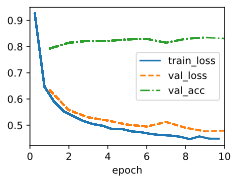

In [23]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

### Prediction

With training finished, the model is now prepared to perform image classification.

In [24]:
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape

torch.Size([256])

Our main focus is on the images that were misclassified. We display them by showing their true labels (top line of the text output) alongside the model’s predicted labels (bottom line).

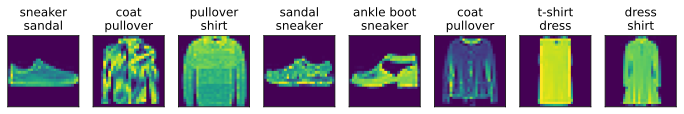

In [25]:
wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)

## Softmax Regression, Concise Implementation

Similar to how high-level deep learning frameworks simplified the implementation of linear regression, they prove equally convenient in this context.

### Defining the Model

In [26]:
class SoftmaxRegression(d2l.Classifier):  #@save
    """The softmax regression model."""
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_outputs))

    def forward(self, X):
        return self.net(X)

### Softmax Revisited

Directly computing softmax followed by cross-entropy can cause numerical instability due to overflow or underflow in the exponentiation step. To address this, modern implementations combine softmax and cross-entropy into a single operation (using techniques like the LogSumExp trick), which ensures stability while still allowing us to compute probabilities when needed.

In [27]:
@d2l.add_to_class(d2l.Classifier)  #@save
def loss(self, Y_hat, Y, averaged=True):
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    Y = Y.reshape((-1,))
    return F.cross_entropy(
        Y_hat, Y, reduction='mean' if averaged else 'none')

### Training

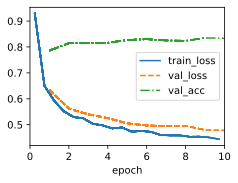

In [28]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## Exercises

### 1. Does reducing the batch_size (for instance, to 1) affect the reading performance?

YES HOLY SHIT

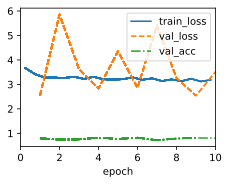

In [29]:
data = d2l.FashionMNIST(batch_size=1)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

### 2. Deep learning uses many different number formats, including FP64 double precision (used extremely rarely), FP32 single precision, BFLOAT16 (good for compressed representations), FP16 (very unstable), TF32 (a new format from NVIDIA), and INT8. Compute the smallest and largest argument of the exponential function for which the result does not lead to numerical underflow or overflow.

In [31]:
import numpy as np
np.log(np.finfo(np.float32).tiny), np.log(np.finfo(np.float32).max)


(-87.33655, 88.72284)

In [32]:
def stable_softmax(X):
    X_shifted = X - X.max(dim=1, keepdim=True).values
    X_exp = torch.exp(X_shifted)
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition

In [37]:
X = torch.rand((2, 5)) * 1000
X_prob = stable_softmax(X)
X_prob, X_prob.sum(1)

(tensor([[1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.]]),
 tensor([1., 1.]))

In [38]:
y = torch.tensor([0, 2])
y_hat = stable_softmax(torch.tensor([[1000.0, 2000.0, 3000.0],
                                     [3000.0, 2000.0, 1000.0]]))
cross_entropy(y_hat, y, test=True)

print the highest probabilities tensor([0., 0.])
and their logarithm tensor([-inf, -inf])


tensor(inf)

In [39]:
y_hat = stable_softmax(torch.tensor([[1.0, 2.0, 3.0],
                                     [3.0, 2.0, 1.0]]))
cross_entropy(y_hat, y, test=True)

print the highest probabilities tensor([0.0900, 0.0900])
and their logarithm tensor([-2.4076, -2.4076])


tensor(2.4076)

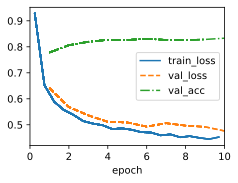

In [36]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [40]:
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape

torch.Size([256])

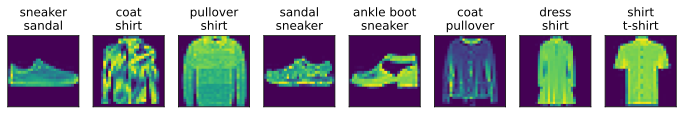

In [41]:
wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)